LSTM 기반의 온실내 온도 예측 - neoWizard

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [2]:
raw_df = pd.read_csv('./climate_data.csv')  # 온실 환경 데이터
raw_df.head()

,seq_no,inside_temp,Outside_temp,outside_RH,Radiation_intensity,Rail_Heating,AHU_Cooling,Fan_speed,inlet_vent_position
0,1,19.8,24.1,100,0.0,0.0,-3.50,440.0,0.0
1,2,19.7,24.2,100,0.0,0.0,-3.50,294.3,0.0
2,3,19.6,24.1,100,0.0,0.0,-3.50,283.3,0.0
3,4,19.6,24.2,100,0.0,0.0,-3.25,272.3,0.0
4,5,19.5,24.0,100,0.0,0.0,-3.75,261.3,0.0


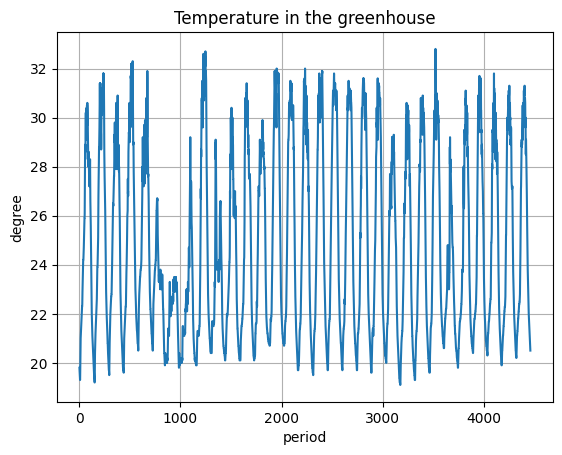

In [3]:
plt.title('Temperature in the greenhouse')
plt.ylabel('degree')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['inside_temp'], label='inside_temp')

plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [4]:
# 통계정보 확인

raw_df.describe()

,seq_no,inside_temp,Outside_temp,outside_RH,Radiation_intensity,Rail_Heating,AHU_Cooling,Fan_speed,inlet_vent_position
count,4464.00000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000
mean,2232.50000,24.809588,27.679570,88.036066,197.308065,0.639897,-3.506272,603.093884,34.867204
std,1288.79013,3.825128,2.585785,10.657682,278.098372,1.400272,2.570764,242.322319,44.631006
min,1.00000,19.100000,21.900000,52.000000,0.000000,-0.250000,-9.250000,0.000000,0.000000
25%,1116.75000,21.400000,26.000000,82.000000,0.000000,0.000000,-5.250000,349.300000,0.000000
50%,2232.50000,23.700000,27.300000,91.000000,32.750000,0.000000,-3.750000,682.000000,0.000000
75%,3348.25000,28.500000,29.300000,97.000000,334.150000,0.000000,-1.500000,879.800000,95.125000
max,4464.00000,32.800000,35.800000,100.000000,1033.600000,10.750000,0.250000,880.800000,100.000000


In [5]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['inside_temp', 'Outside_temp', 'outside_RH', 'Radiation_intensity', 'Rail_Heating',
              'AHU_Cooling', 'Fan_speed', 'inlet_vent_position']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

      inside_temp  Outside_temp  outside_RH  Radiation_intensity  \
0        0.051095      0.158273    1.000000                  0.0   
1        0.043796      0.165468    1.000000                  0.0   
2        0.036496      0.158273    1.000000                  0.0   
3        0.036496      0.165468    1.000000                  0.0   
4        0.029197      0.151079    1.000000                  0.0   
...           ...           ...         ...                  ...   
4459     0.124088      0.258993    0.916667                  0.0   
4460     0.116788      0.237410    0.916667                  0.0   
4461     0.109489      0.244604    0.916667                  0.0   
4462     0.109489      0.266187    0.875000                  0.0   
4463     0.102190      0.287770    0.854167                  0.0   

      Rail_Heating  AHU_Cooling  Fan_speed  inlet_vent_position  
0         0.022727     0.605263   0.499546                  0.0  
1         0.022727     0.605263   0.334128         

 - 시계열 데이터를 위한 window_size = 30 선정

In [6]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [7]:
# feature_df, label_df 생성

feature_cols = ['inside_temp','Outside_temp', 'outside_RH', 'Radiation_intensity', 'Rail_Heating',
              'AHU_Cooling', 'Fan_speed', 'inlet_vent_position']
label_cols = [ 'inside_temp' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [8]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(4464, 8) (4464, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [11]:
window_size = 30

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(4434, 30, 8) (4434, 1)


학습데이터, 테스트데이터 생성

In [12]:
# train, test 분리

#split = int(len(X)*0.80)
split = -392

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4042, 30, 8) (4042, 1)
(392, 30, 8) (392, 1)


모델 구축 및 컴파일

In [13]:
# model 생성

model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

model.add(Dense(1, activation='linear'))

In [14]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable params: 0
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100
253/253 [==============================] - 4s 12ms/step - loss: 0.0049 - mae: 0.0441 - val_loss: 0.0020 - val_mae: 0.0318
Epoch 2/100
253/253 [==============================] - 3s 10ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0015 - val_mae: 0.0309
Epoch 3/100
253/253 [==============================] - 3s 10ms/step - loss: 0.0012 - mae: 0.0240 - val_loss: 9.5585e-04 - val_mae: 0.0202
Epoch 4/100
253/253 [==============================] - 3s 10ms/step - loss: 0.0011 - mae: 0.0229 - val_loss: 9.1945e-04 - val_mae: 0.0207
Epoch 5/100
253/253 [==============================] - 3s 10ms/step - loss: 9.4941e-04 - mae: 0.0212 - val_loss: 7.6711e-04 - val_mae: 0.0181
Epoch 6/100
253/253 [==============================] - 3s 10ms/step - loss: 8.3784e-04 - mae: 0.0197 - val_loss: 8.1503e-04 - val_mae: 0.0191
Epoch 7/100
253/253 [==============================] - 3s 10ms/step - loss: 7.8520e-04 - mae: 0.0189 - val_loss: 7.2414e-04 - val_mae: 0.0181
Epoch 8/100
253/253 [=========

예측을 통한 정답과의 비교 
(오차계산 MAPE 사용, 평균절대값백분율오차)

13/13 [==============================] - 0s 4ms/step


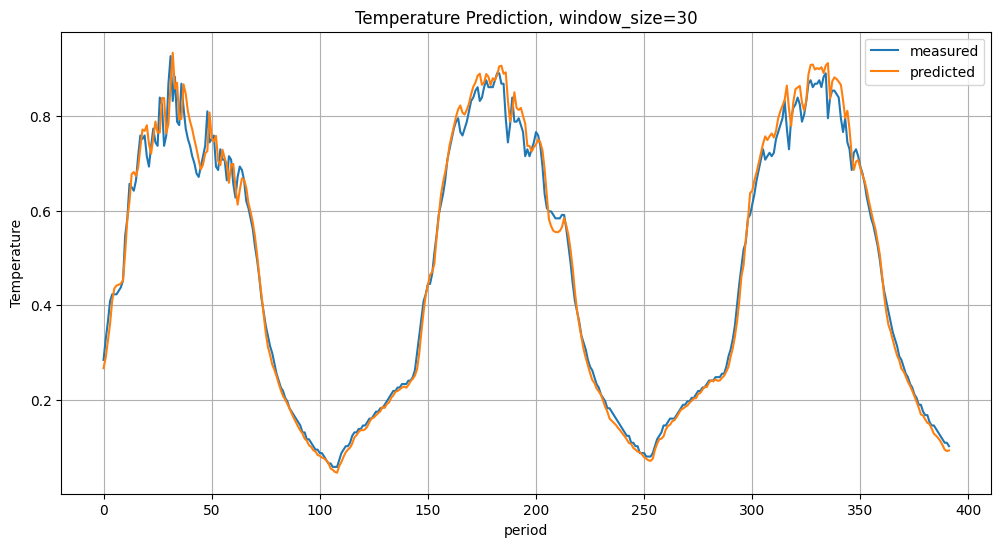

In [16]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('Temperature Prediction')
plt.ylabel('Temperature')
plt.xlabel('period')
plt.plot(y_test, label='measured')
plt.plot(pred, label='predicted')
plt.grid()
plt.legend(loc='best')

plt.show()

In [52]:
# 평균절대값백분율오차계산 (MAPE)

print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.040724602222207584
